In [6]:
import numpy as np
import matplotlib.pyplot as plt
import discretize
from SimPEG.potential_fields import magnetics as mag
from SimPEG import (
    maps,
    data,
    data_misfit,
    inverse_problem,
    regularization,
    optimization,
    directives,
    inversion,
)

In [2]:
hx = np.full(64, 50)
hy = np.full(64, 50)
hz = np.full(16, 50)
mesh = discretize.TensorMesh([hx, hy, hz], x0='CCN')
mesh

TensorMesh: 65,536 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x     64     -1,600.00      1,600.00     50.00     50.00    1.00
   y     64     -1,600.00      1,600.00     50.00     50.00    1.00
   z     16       -800.00          0.00     50.00     50.00    1.00

In [27]:
#Underground arc model
center = np.r_[0, 0, 600]
normal = np.r_[1, 1, 0]
normal = normal/np.linalg.norm(normal)
radius = 1000 #m
thickness = 200 #m

cell_centers = mesh.cell_centers

# distance from circle
delta = cell_centers - center
dotND = np.dot(cell_centers, normal)
QmC = delta - dotND[:, None] * normal[None, :]
lengthQmC = np.linalg.norm(QmC, axis=-1)

distances = np.empty(cell_centers.shape[0])

inds1 = lengthQmC > 0
cross_nd = np.cross(normal, delta[inds1])
radial = np.linalg.norm(cross_nd, axis=-1) - radius
distances[inds1] = np.sqrt(dotND * dotND + radial * radial)

distances[~inds1] = np.sqrt(np.sum(delta[~inds1] * delta[~inds1], axis=-1) + radius * radius)

arc = distances < thickness
model = np.zeros(mesh.n_cells)
model[arc] = 0.1

In [4]:
# make grid of magnetic data sets
rx_xyz = np.mgrid[-1500:1500:33j, -1500:1500:33j, 100:100:1j].reshape(3, -1).T

# Make a northern hemisphere location for inducing field
# Say Golden, CO

# Declination : 7° 47' 29"
# Inclination : 65° 58' 12"
# Total Field 51,345.6 nT
declination = 7 + 47/60 + 29/(60*60)
inclination = 65 + 58/60 + 12/(60 * 60)
b0 = 51_345.6

rx = mag.Point(rx_xyz, components='tmi')
src = mag.UniformBackgroundField(rx, b0, inclination, declination)
srv = mag.Survey(src)

In [7]:
sim = mag.Simulation3DIntegral(mesh, survey=srv, chiMap=maps.IdentityMap(mesh))

In [28]:
np.random.seed(454213)
data_object = sim.make_synthetic_data(model, relative_error=0, noise_floor=5, add_noise=True)
d_clean = data_object.dclean
d_obs = data_object.dobs

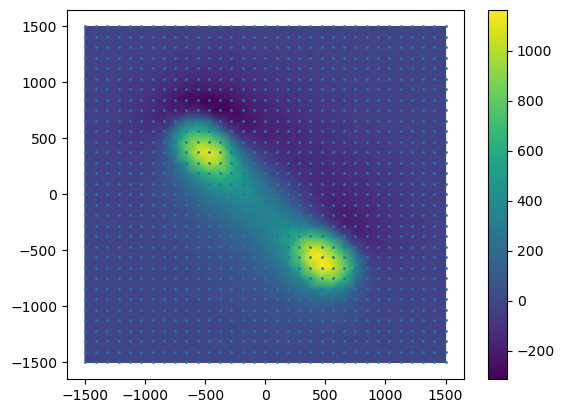

In [29]:
plt.tripcolor(rx_xyz[:, 0], rx_xyz[:, 1], d_obs, shading='gouraud')
plt.colorbar()
plt.scatter(rx_xyz[:, 0], rx_xyz[:, 1], s=1)

In [39]:
dmis = data_misfit.L2DataMisfit(data=data_object, simulation=sim)

# Define the regularization (model objective function).
reg = regularization.WeightedLeastSquares(mesh)

# Define how the optimization problem is solved. Here we will use a projected
# Gauss-Newton approach that employs the conjugate gradient solver.
opt = optimization.ProjectedGNCG(
    maxIter=20, lower=0, upper=1, maxIterLS=20, maxIterCG=100, tolCG=1e-5
)

# Here we define the inverse problem that is to be solved
inv_prob = inverse_problem.BaseInvProblem(dmis, reg, opt)

In [40]:
# Defining a starting value for the trade-off parameter (beta) between the data
# misfit and the regularization.
starting_beta = directives.BetaEstimate_ByEig(beta0_ratio=1e4)

# Defining the fractional decrease in beta and the number of Gauss-Newton solves
# for each beta value.
beta_schedule = directives.BetaSchedule(coolingFactor=5, coolingRate=1)

# Options for outputting recovered models and predicted data for each beta.
save_iteration = directives.SaveOutputEveryIteration(save_txt=False)

# Updating the preconditionner if it is model dependent.
update_jacobi = directives.UpdatePreconditioner()

# Setting a stopping criteria for the inversion.
target_misfit = directives.TargetMisfit(chifact=1)

# Add sensitivity weights
sensitivity_weights = directives.UpdateSensitivityWeights(every_iteration=False)

# The directives are defined as a list.
directives_list = [
    sensitivity_weights,
    starting_beta,
    beta_schedule,
    save_iteration,
    update_jacobi,
    target_misfit,
]

In [42]:
# Here we combine the inverse problem and the set of directives
inv = inversion.BaseInversion(inv_prob, directives_list)

m_0 = np.zeros(mesh.n_cells)+0.05
# Run inversion
recovered_model = inv.run(m_0)

I:\miniforge3\envs\gpgn-318\Lib\site-packages\SimPEG\directives\directives.py:320: UserWarning: InversionDirective UpdateSensitivityWeights has switched to a new inversion.
  d.inversion = i
I:\miniforge3\envs\gpgn-318\Lib\site-packages\SimPEG\directives\directives.py:320: UserWarning: InversionDirective BetaEstimate_ByEig has switched to a new inversion.
  d.inversion = i
I:\miniforge3\envs\gpgn-318\Lib\site-packages\SimPEG\directives\directives.py:320: UserWarning: InversionDirective BetaSchedule has switched to a new inversion.
  d.inversion = i
I:\miniforge3\envs\gpgn-318\Lib\site-packages\SimPEG\directives\directives.py:320: UserWarning: InversionDirective SaveOutputEveryIteration has switched to a new inversion.
  d.inversion = i
I:\miniforge3\envs\gpgn-318\Lib\site-packages\SimPEG\directives\directives.py:320: UserWarning: InversionDirective UpdatePreconditioner has switched to a new inversion.
  d.inversion = i
I:\miniforge3\envs\gpgn-318\Lib\site-packages\SimPEG\directives\dir

The callback on the ProjectedGNCG Optimization was replaced.

                    SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                    ***Done using the default solver Pardiso and no solver_opts.***
                    
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  2.75e+03  5.20e+06  1.51e+06  4.16e+09    1.28e+01      0   Skip BFGS  
   1  5.51e+02  8.35e+05  8.48e-01  8.36e+05    1.34e+02      0   Skip BFGS  
   2  1.10e+02  8.17e+05  2.07e+01  8.19e+05    1.33e+02      0              
   3  2.20e+01  7.36e+05  4.53e+02  7.46e+05    1.30e+02      0   Skip BFGS  
   4  4.41e+00  4.86e+05  6.67e+03  5.15e+05    1.23e+02      0   Skip BFGS  
   5  8.81e-01  1.67e+05  4.11e+04  2.03e+05    1.28e+02      0   Skip BFGS  
 

In [47]:
pv_mesh = mesh.to_vtk(models={'chi':recovered_model})

thresh = pv_mesh.threshold(0.04)
thresh.plot(jupyter_backend='trame')

Widget(value="<iframe src='http://localhost:62242/index.html?ui=P_0x2819664f090_11&reconnect=auto' style='widt…